In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class DPGMM:
    def __init__(self, alpha=1, mu0=0, rho0=1, a0=1, b0=1, max_iter=30):
        self.alpha = alpha
        self.mu0 = mu0
        self.rho0 = rho0
        self.a0 = a0
        self.b0 = b0
        self.max_iter = max_iter

    def _init_z(self):
        z = []
        for i in range(self._N):
            z.append(-1)
        return np.array(z)

    def _init_gamma(self):
        return np.random.gamma(self.a0, self.b0)

    def _init_mu(self):
        return np.random.normal(self.mu0, np.sqrt(1.0 / (self.rho0 * self.gamma)), size=self._D)

    def _sample_z(self):
        for i in range(self._N):
            old_k = self.z[i]
            if old_k != -1:
                if self.n[old_k] == 1:
                    del self.n[old_k]
                    del self.mu[old_k]
                else:
                    self.n[old_k] -= 1
            prob = []
            classes = {}
            _k = 0
            for k in self.n:
                if k == self.new_class:
                    mu = self._init_mu()
                    pi = self.alpha
                    new_mu = mu.copy()
                else:
                    mu = self.mu[k]
                    pi = self.n[k]
                prob.append(self._Gaussian_pdf(
                    self._X[i], mu, self.gamma) * pi)
                classes[_k] = k
                _k += 1
            prob = np.array(prob)
            prob = prob / prob.sum()
            new_k = classes[np.random.multinomial(1, prob, size=1).argmax()]
            self.z[i] = new_k
            self.n[new_k] += 1
            if new_k == self.new_class:
                self.mu[self.new_class] = new_mu
                j = 0
                while True:
                    if not j in self.n:
                        self.n[j] = 0
                        self.new_class = j
                        break
                    j += 1

    def _calc_x_bar(self):
        x_bar = {}
        for i in range(self._N):
            k = self.z[i]
            if not k in x_bar:
                x_bar[k] = 0
            x_bar[k] += self._X[i]
        for k in x_bar:
            x_bar[k] /= self.n[k]
        return x_bar

    def _sample_mu(self):
        x_bar = self._calc_x_bar()
        for k in self.mu:
            loc = (self.n[k] / (self.n[k] + self.rho0)) * x_bar[k] + \
                (self.rho0 / (self.n[k] + self.rho0)) * self.mu0
            scale = np.sqrt(1.0 / (self.gamma * (self.n[k] + self.rho0)))

            self.mu[k] = np.random.normal(
                loc=list(loc), scale=scale, size=self._D)

    def _sample_gamma(self):
        a = self.a0 + (self._N * self._D) / 2.0
        b = self.b0
        x_bar = self._calc_x_bar()
        for k in self.n:
            if self.n[k] == 0:
                continue
            b += (0.5 * self.n[k] * self.rho0 / (self.n[k] +
                                                 self.rho0)) * np.linalg.norm(x_bar[k] - self.mu0)**2
        for i in range(self._N):
            k = self.z[i]
            b += 0.5 * np.linalg.norm(x_bar[k] - self._X[i])**2
        self.gamma = np.random.gamma(a, 1.0 / b)

    def _Gaussian_pdf(self, x, mu, gamma):
        # not normalized
        return np.exp(-0.5 * gamma * np.linalg.norm(x - mu)**2)

    def fit(self, X):
        self._X = X
        self._N = X.shape[0]
        self._D = X.shape[1]
        self.z = self._init_z()
        self.new_class = 0
        self.n = {self.new_class: 0}
        self.mu = {}
        self.gamma = self._init_gamma()
        remained_iter = self.max_iter
        while True:
            self._sample_z()
            self._sample_mu()
            self._sample_gamma()
            if remained_iter <= 0:
                break
            remained_iter -= 1
        return self

    def predict(self, i):
        return self.z[i]

---

In [3]:
points = list()
with open('./points.txt') as file:
    for line in file:
        points.append([float(x) for x in line.strip().split(',')])
points = np.array(points)        

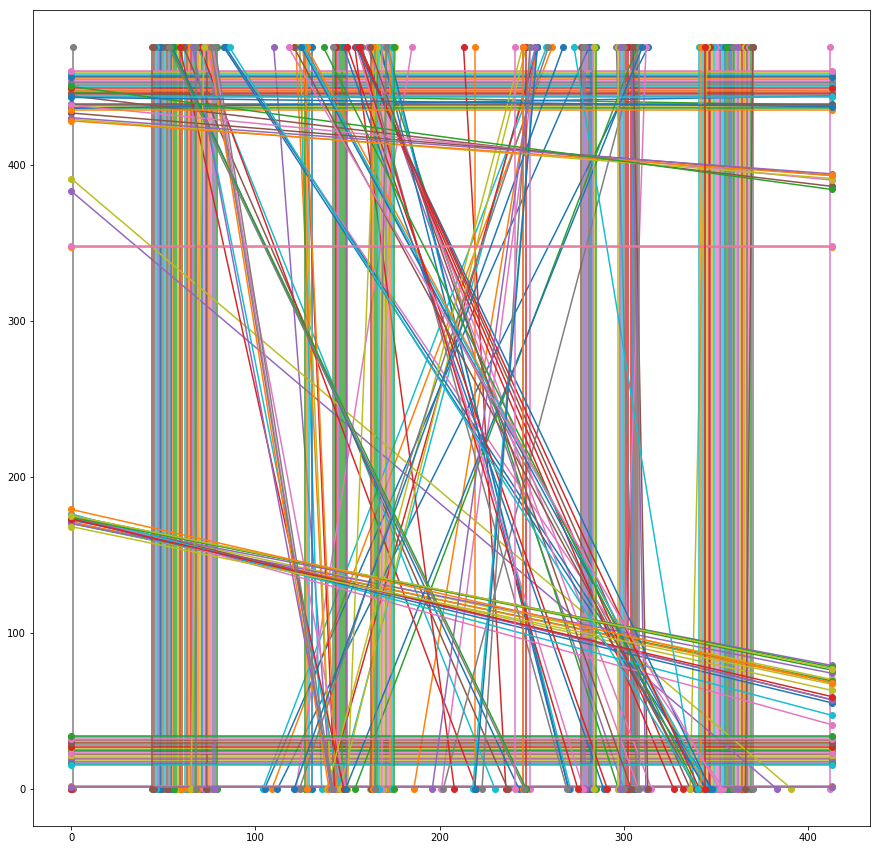

In [4]:
fig = plt.figure(figsize=(15,15))
for x in points:
    plt.plot(x[[0,2]],x[[1,3]],'o-')

In [5]:
X = np.zeros((2*len(points),3))
X[:len(points),:2] = points[:,:2]
X[len(points):,:2] = points[:,2:]

In [6]:
%%time
model = DPGMM(alpha=10, mu0=0, rho0=0.01, a0=1, b0=1, max_iter=200)
model.fit(X[:,:2])

/home/gu/.virtualenvs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 12.2 s, sys: 8.24 ms, total: 12.2 s
Wall time: 12.2 s


In [7]:
labels = [model.predict(i) for i in range(2*len(points))]
labels = [str(set(x)) for x in zip(labels[:len(points)],labels[len(points):])]

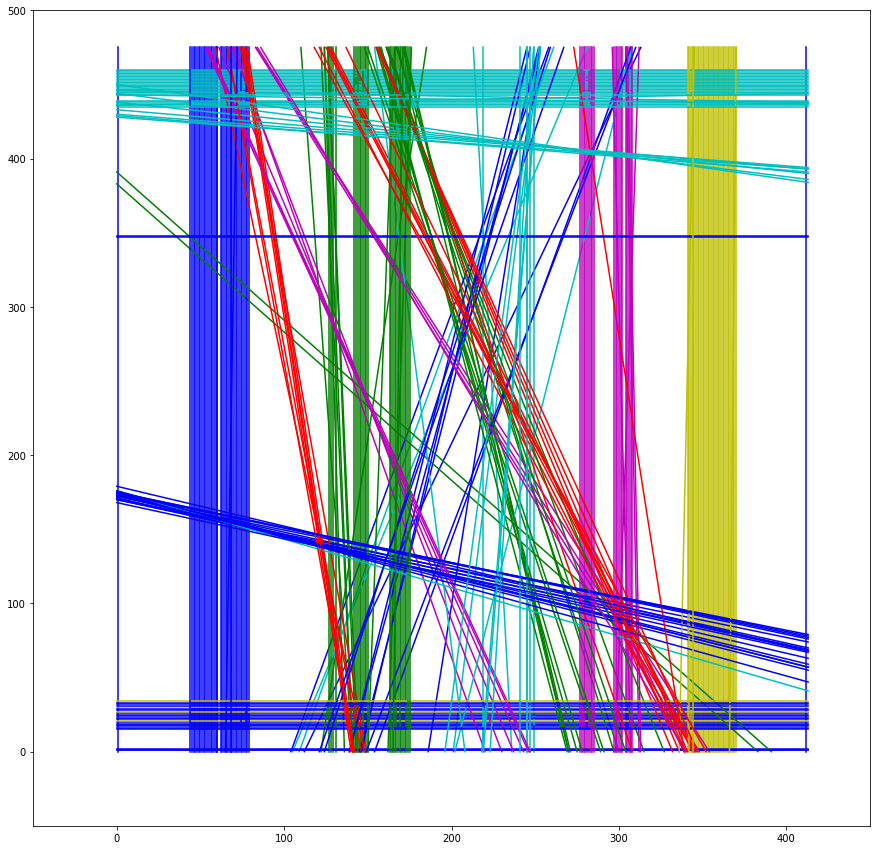

In [8]:
colors = ['r','y','b','m','g','c']
random.shuffle(colors)
color_dict = {label:random.sample(colors,1)[0] for label in set(labels)}
fig = plt.figure(figsize=(15,15))
plt.xlim(-50,450)
plt.ylim(-50,500)
for i,label in enumerate(labels):
    x = points[i]
    plt.plot(x[[0,2]],x[[1,3]],'%s-'%(color_dict[label]))

/home/gu/.virtualenvs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


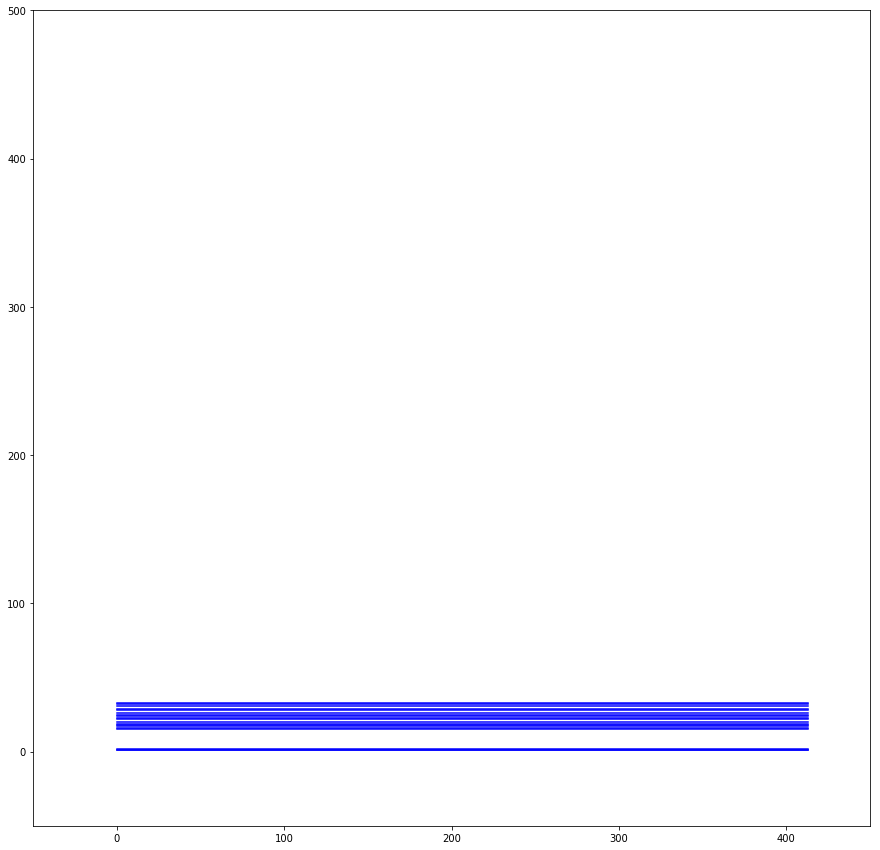

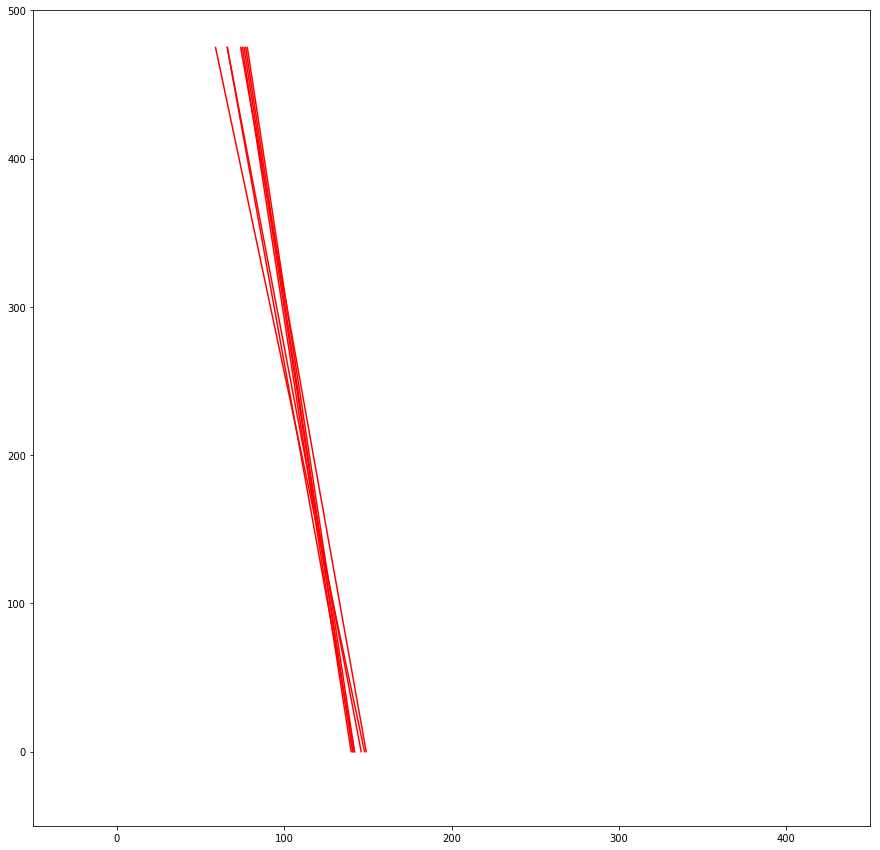

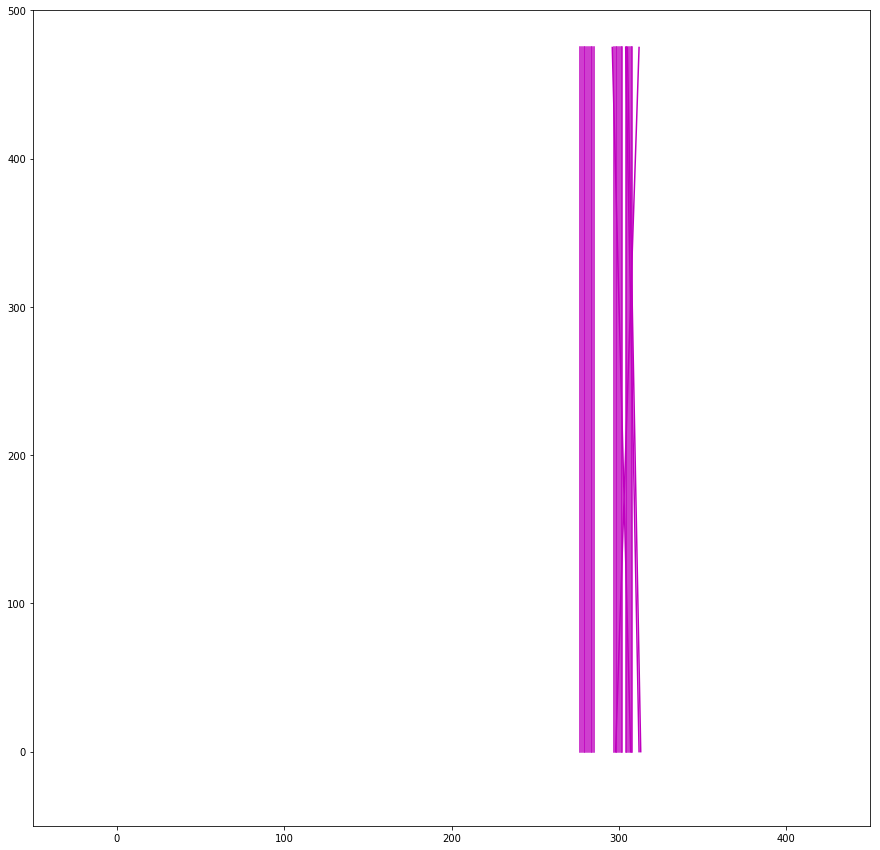

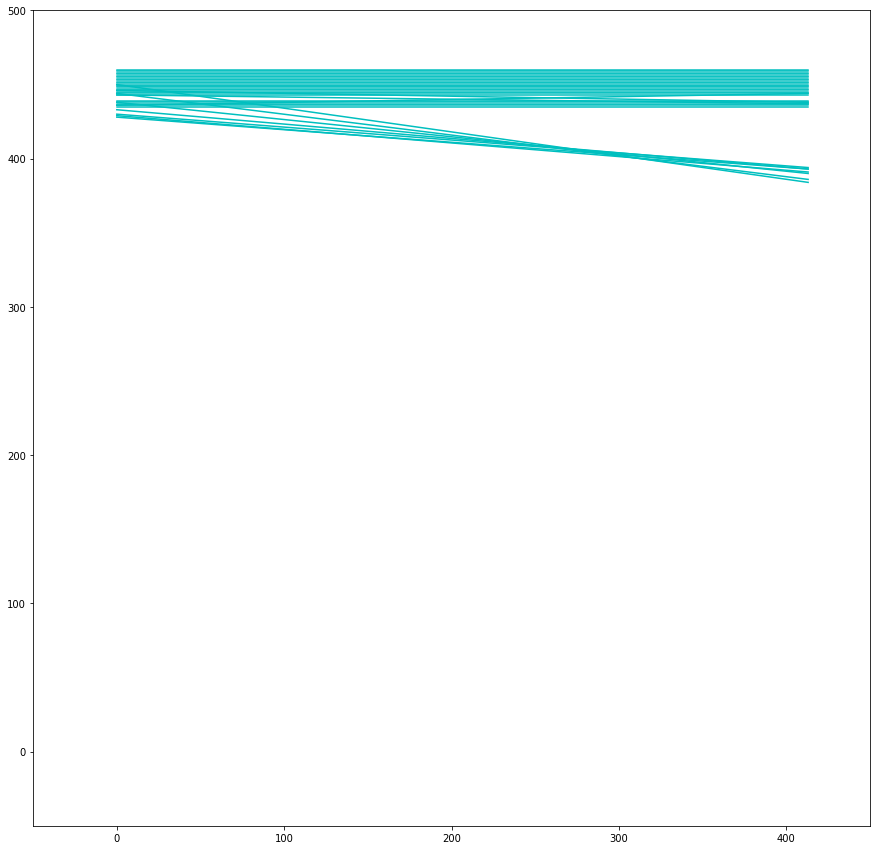

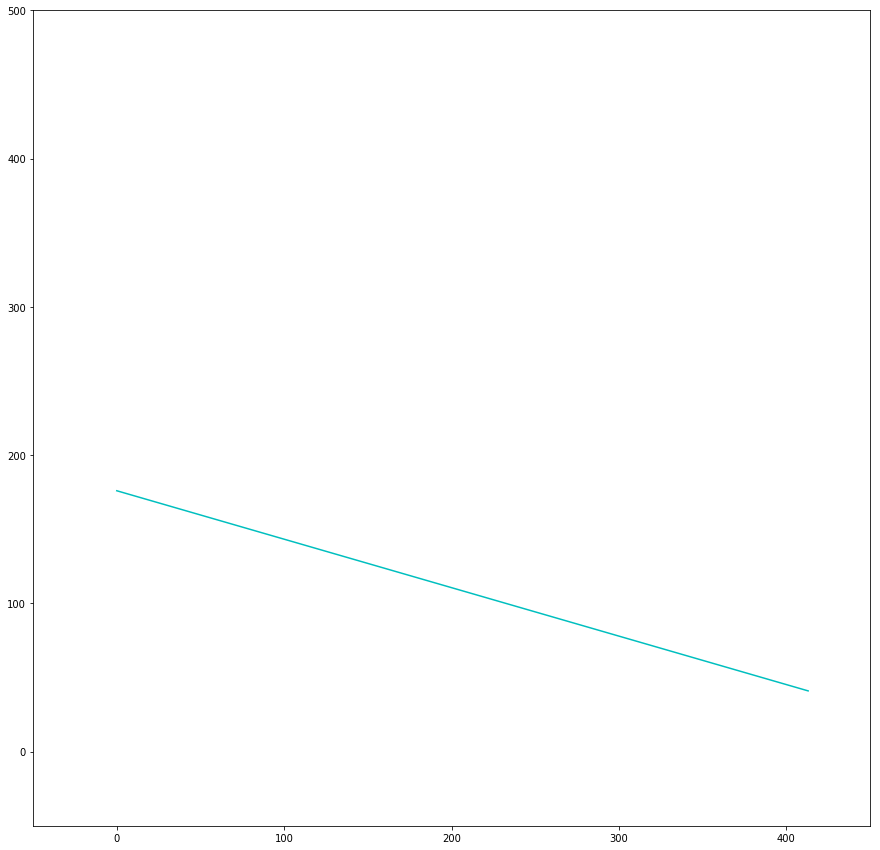

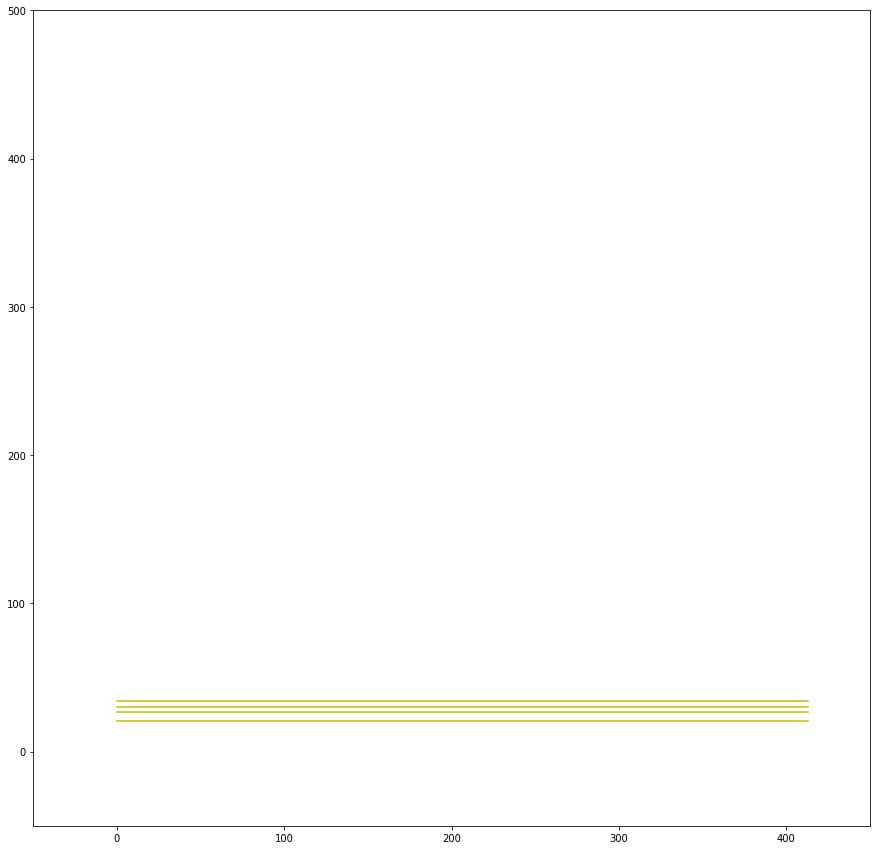

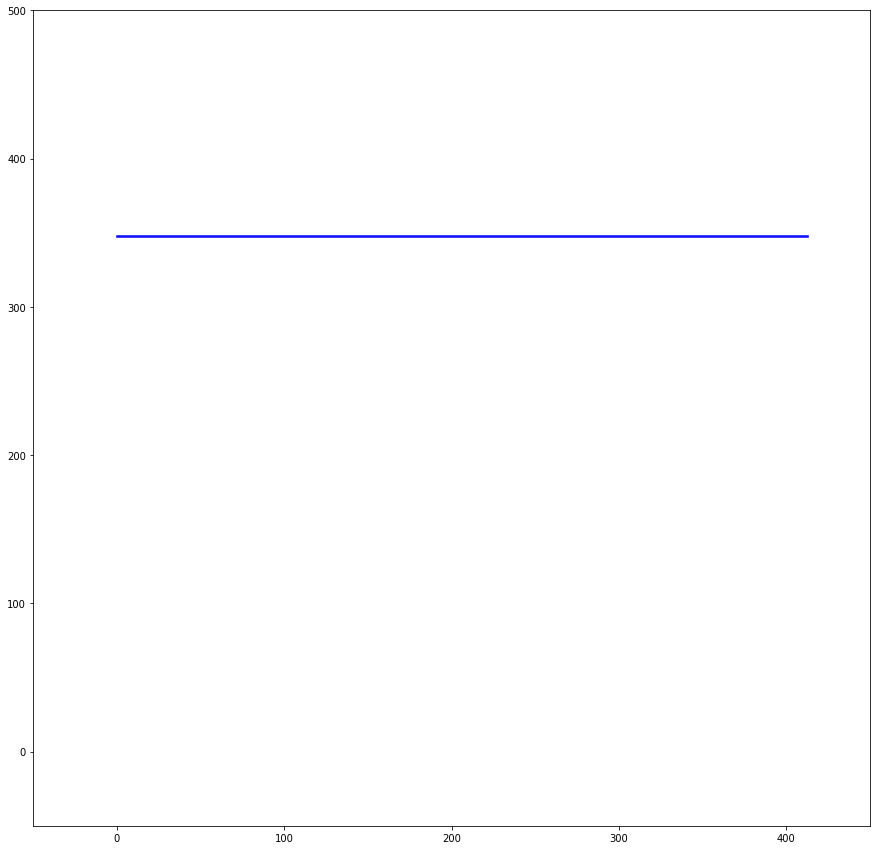

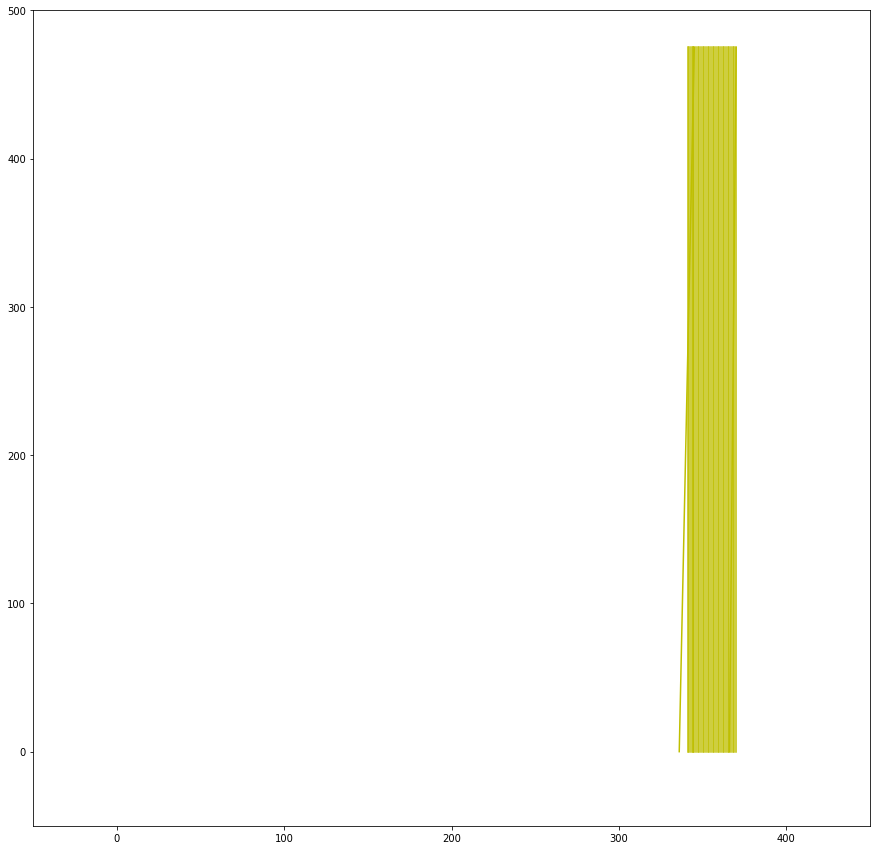

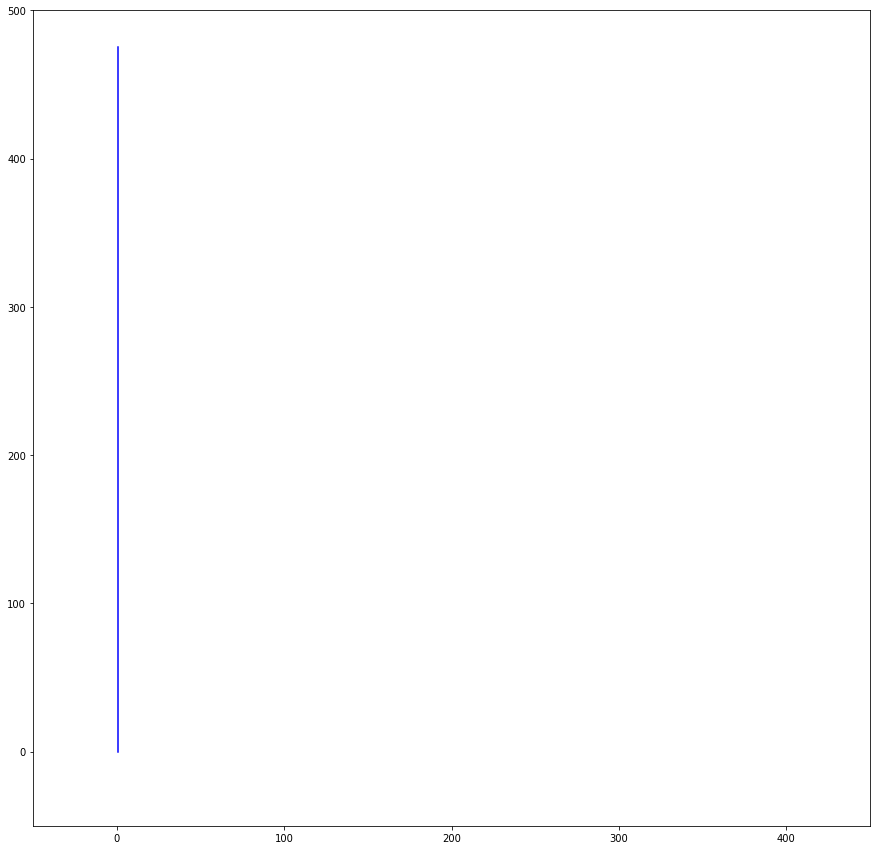

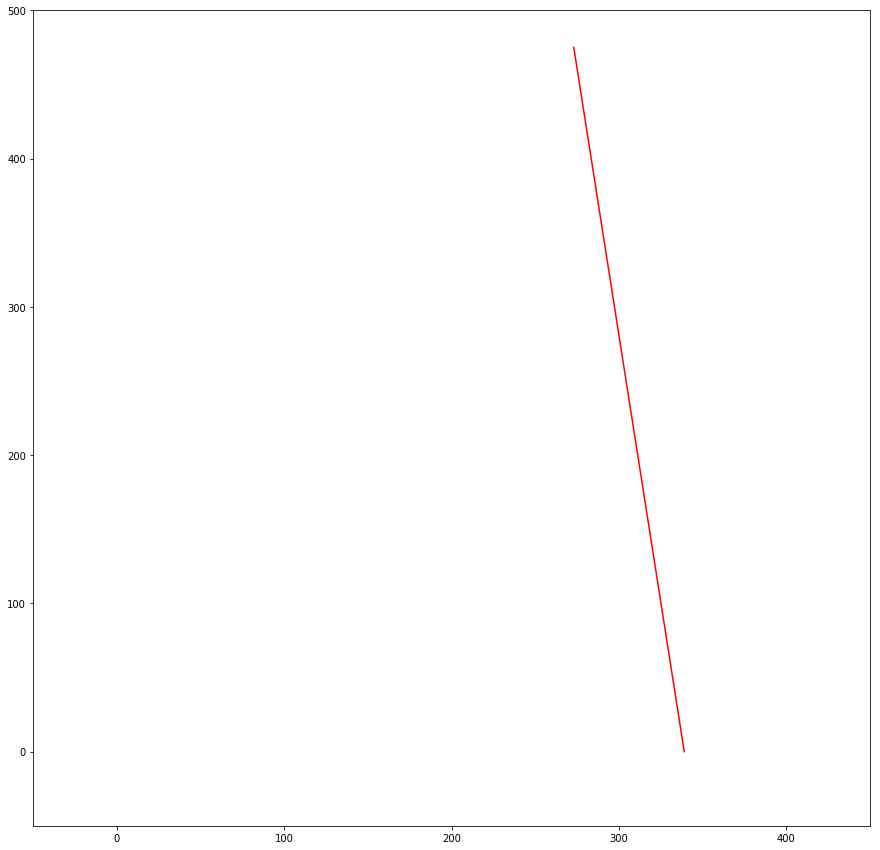

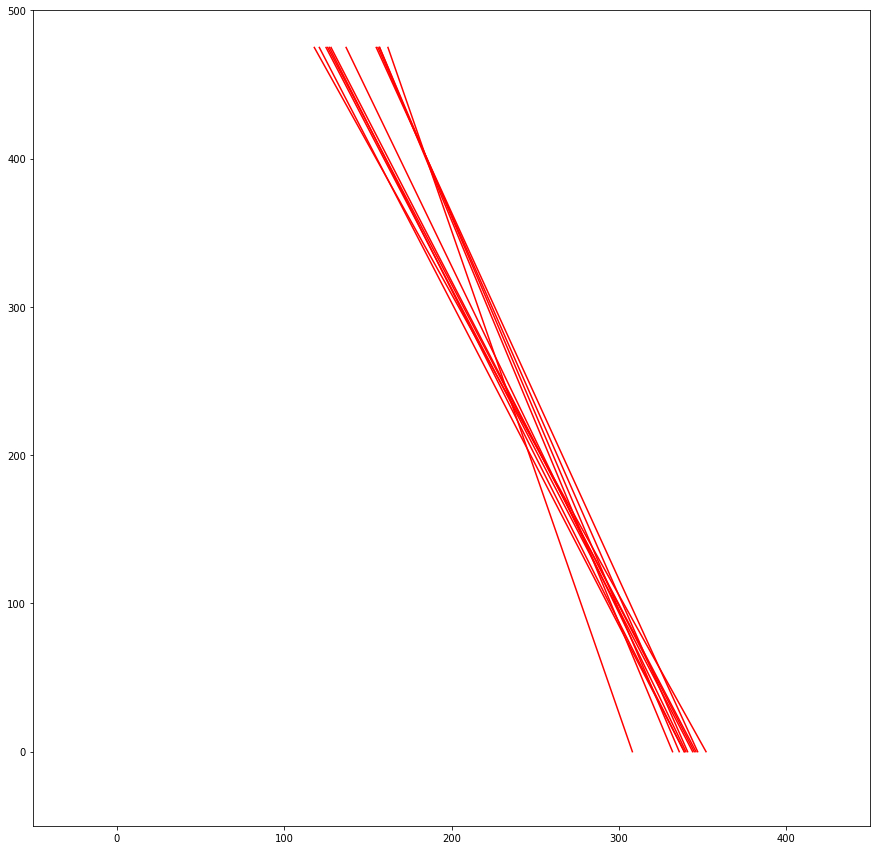

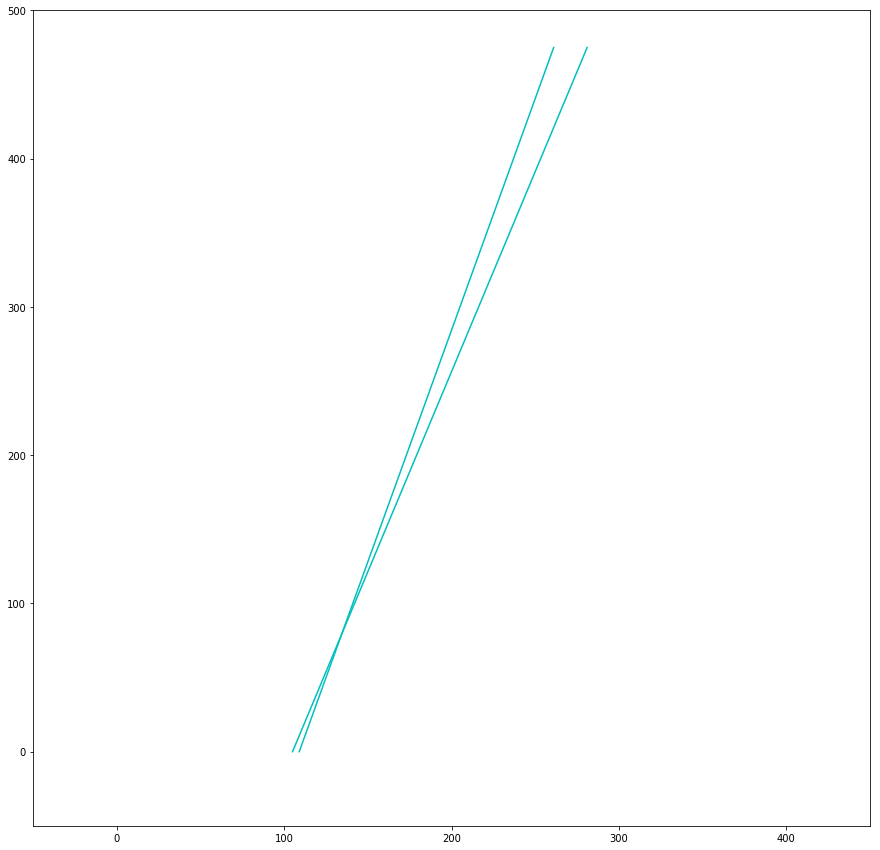

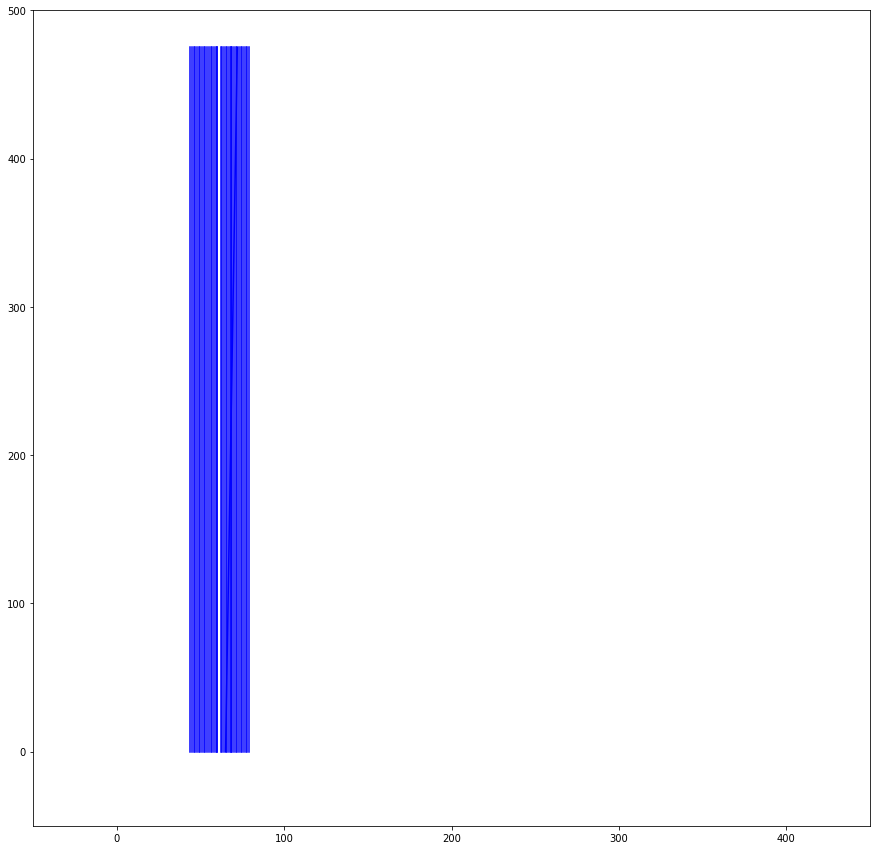

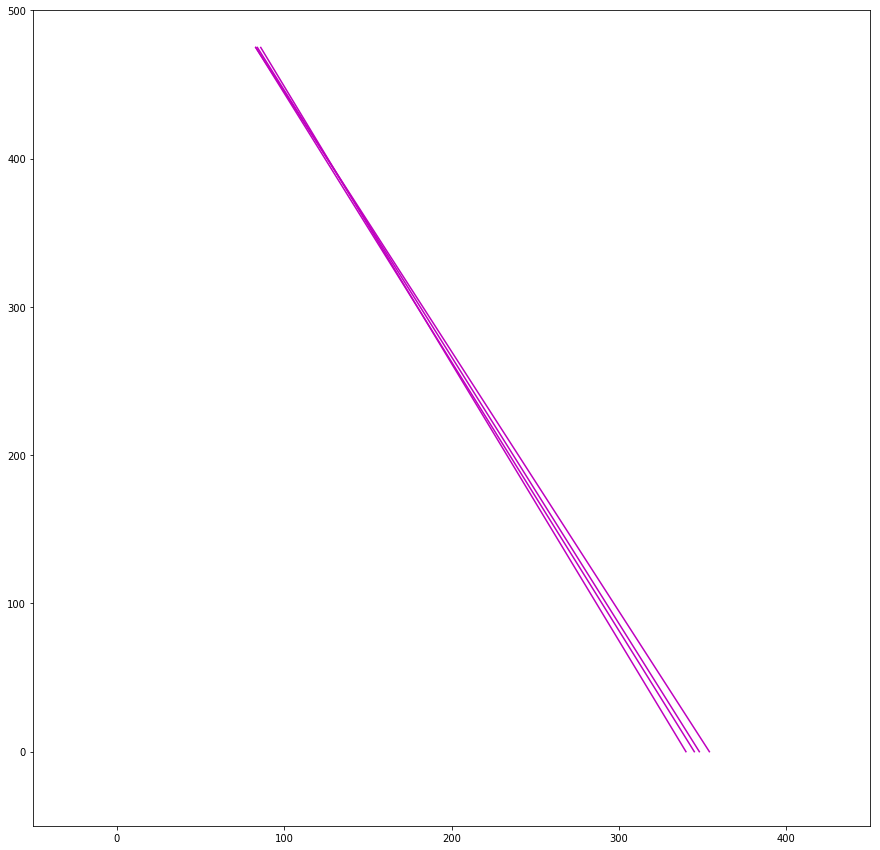

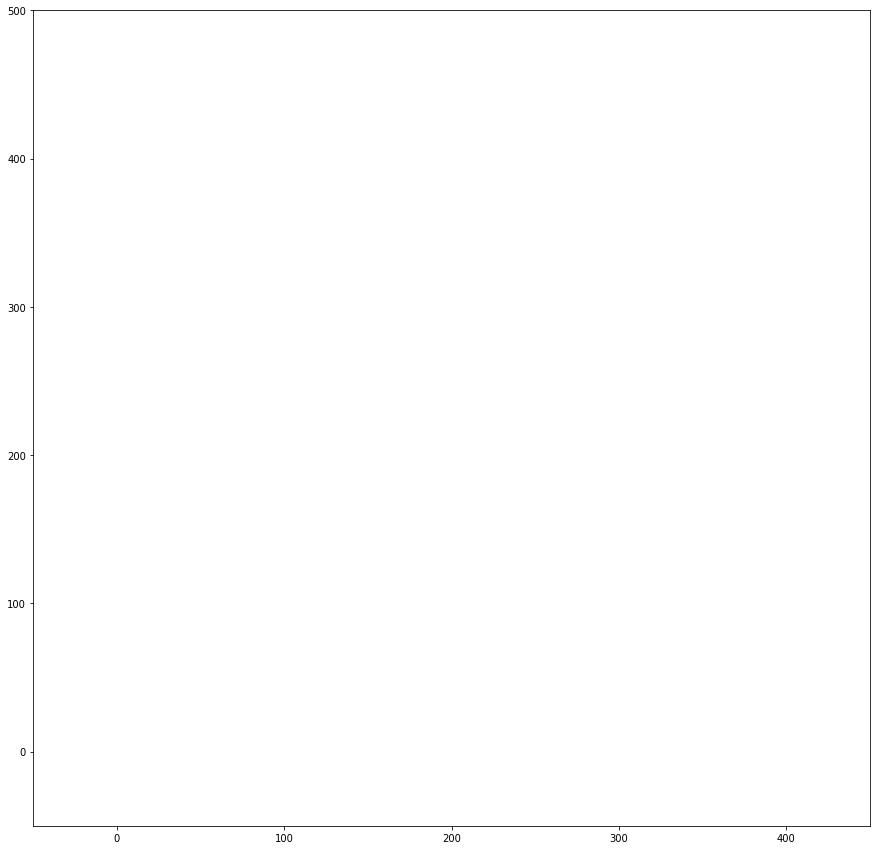

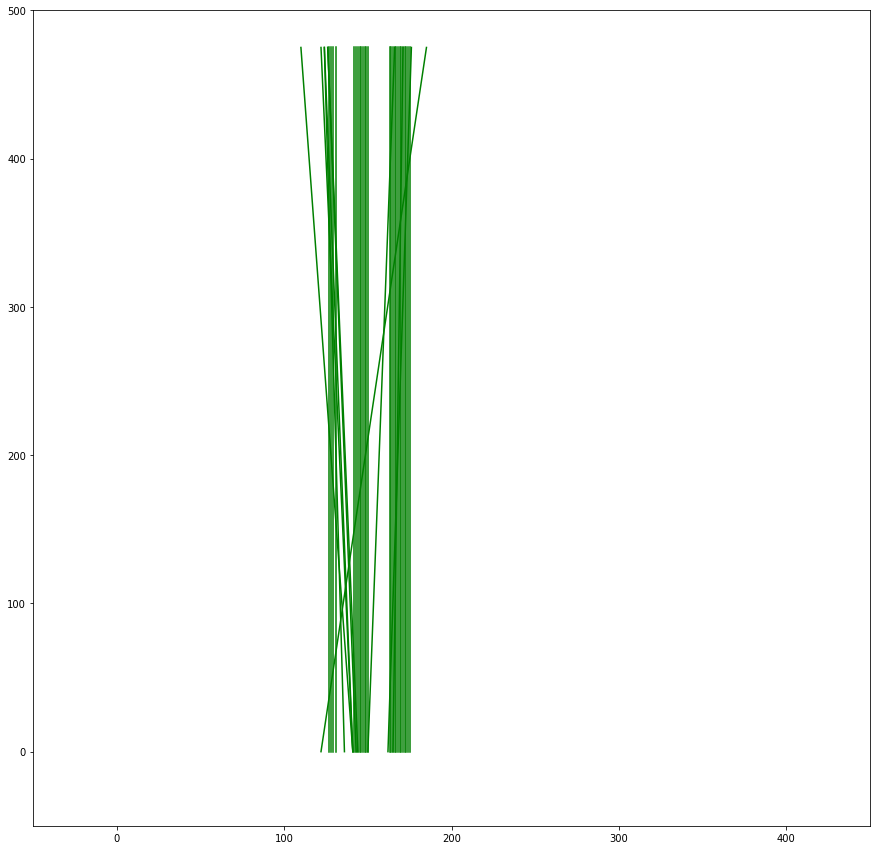

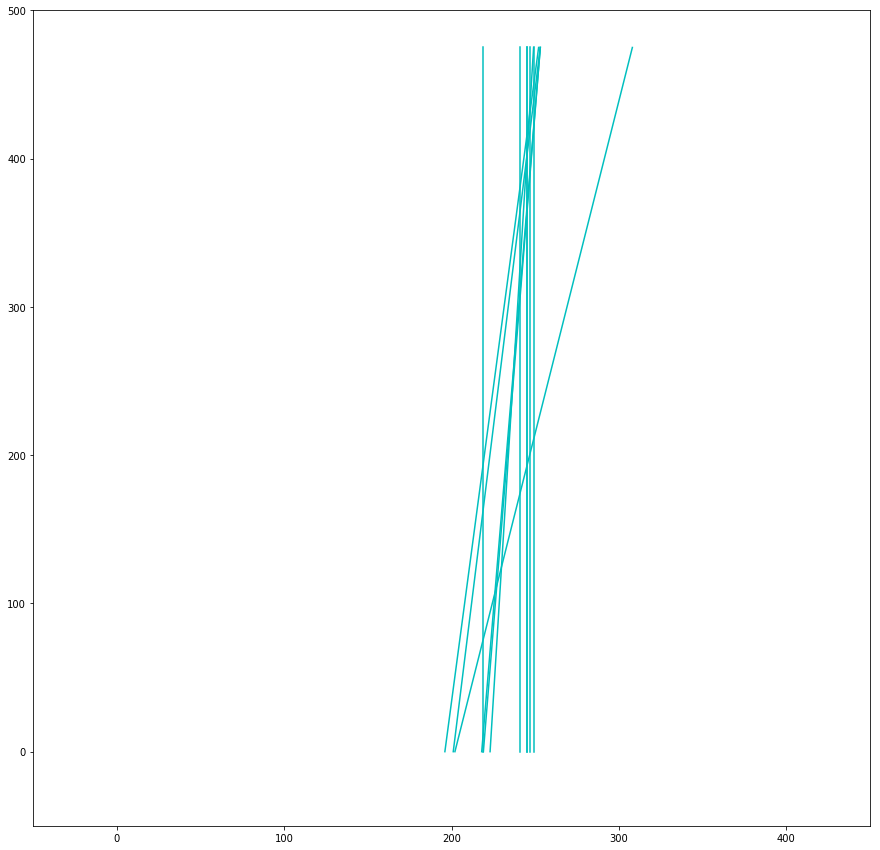

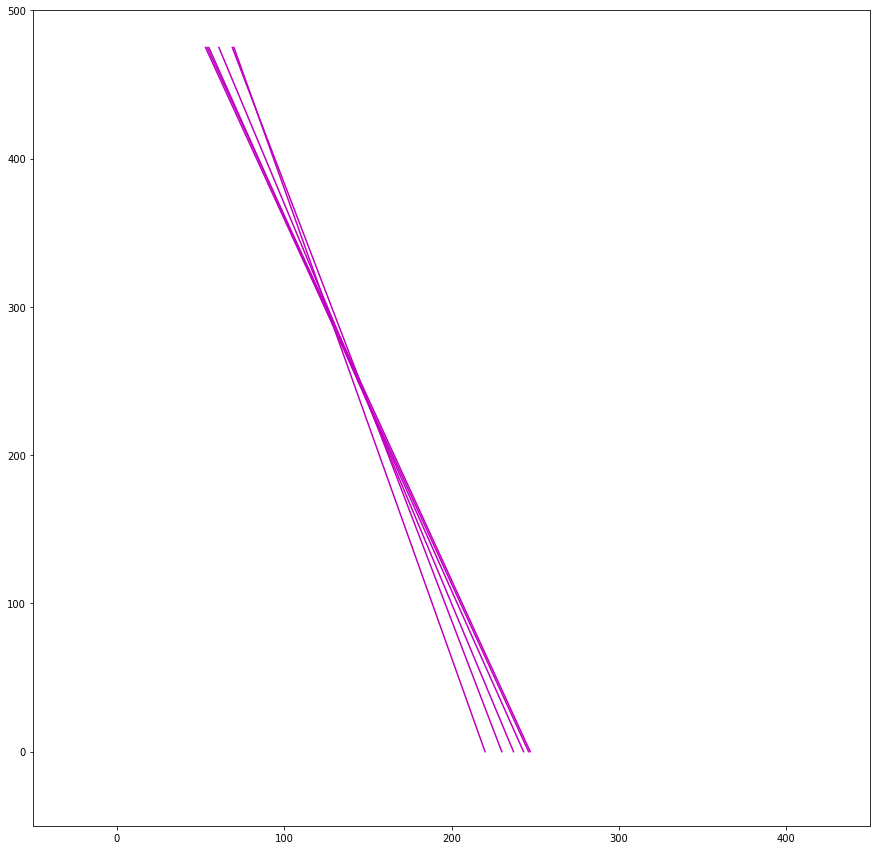

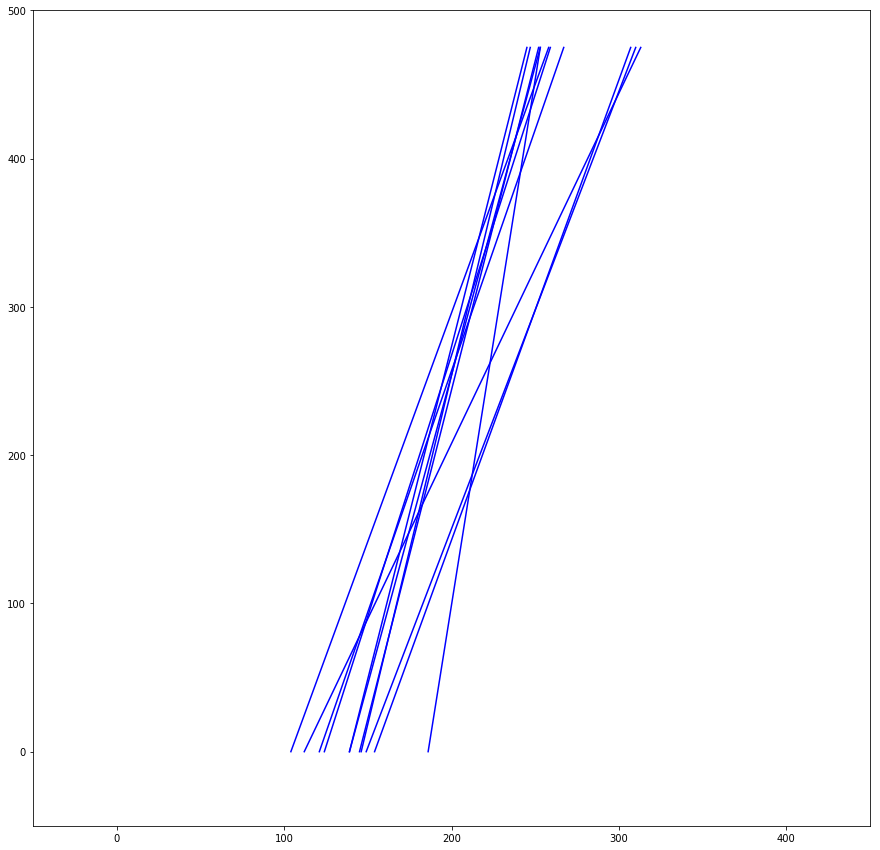

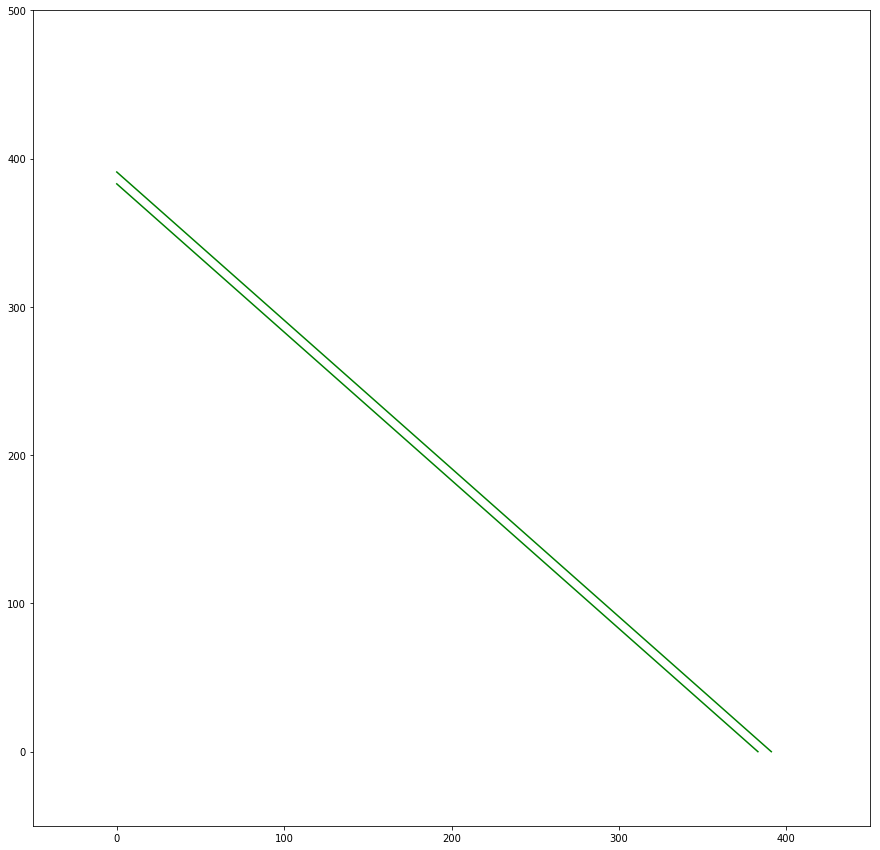

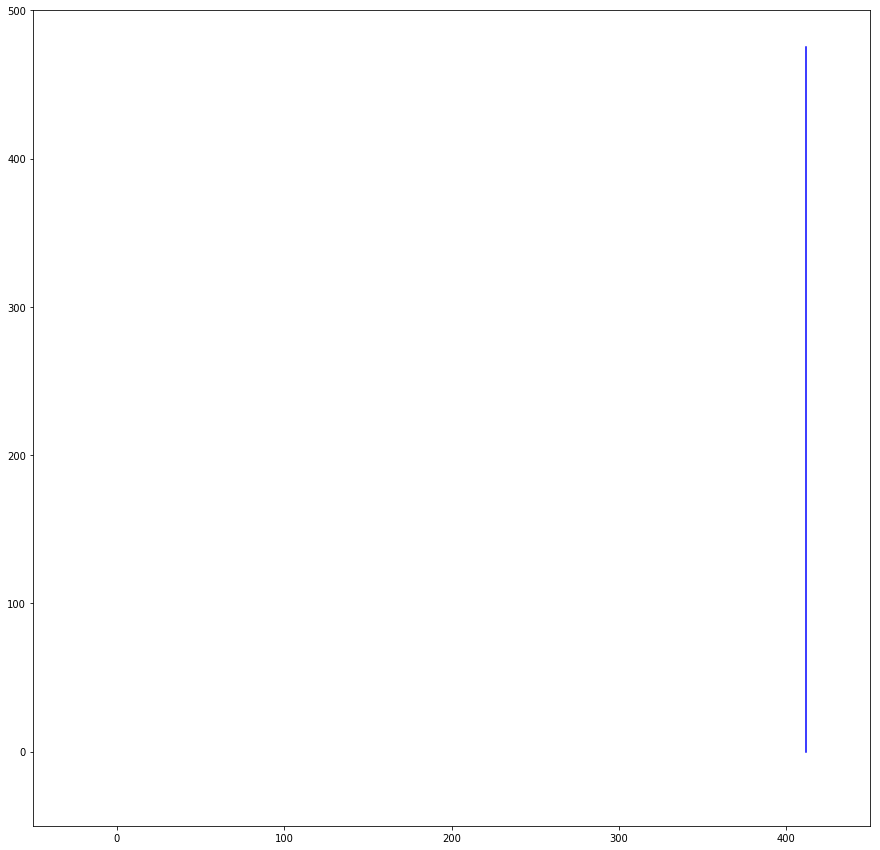

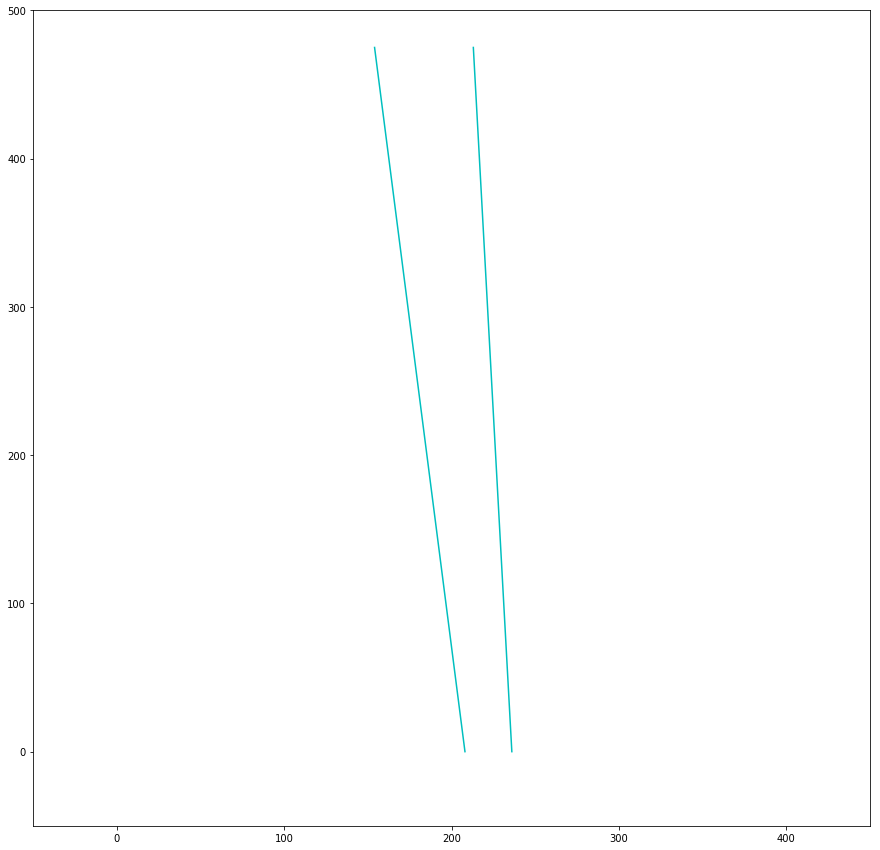

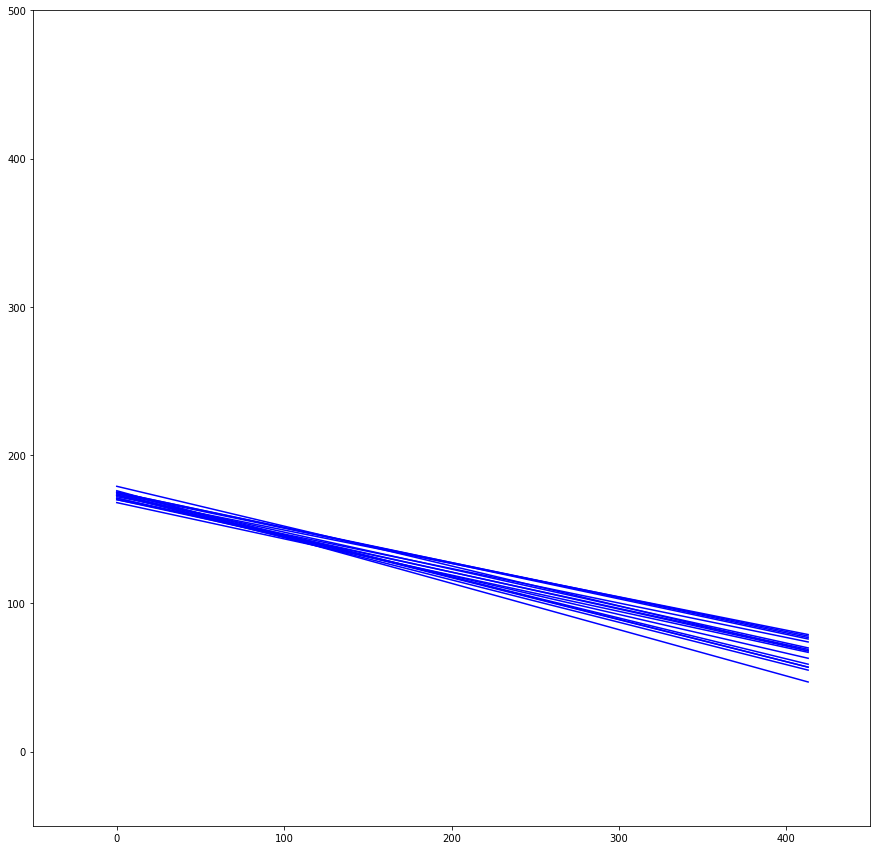

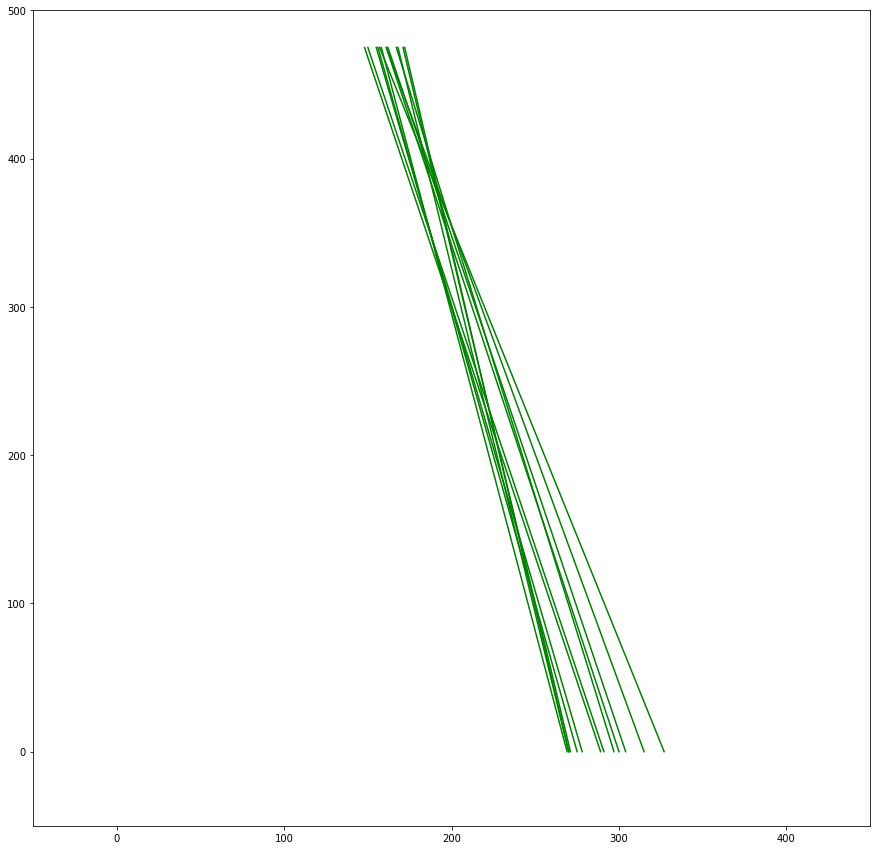

In [9]:
for sl in set(labels):
    fig = plt.figure(figsize=(15,15))
    plt.xlim(-50,450)
    plt.ylim(-50,500)
    for i,label in enumerate(labels):
        if label == sl:
            x = points[i]
            plt.plot(x[[0,2]],x[[1,3]],'%s-'%(color_dict[label]))

In [10]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
